# Settings

In [1]:
import warnings
warnings.filterwarnings("ignore", category=Warning)
# use CUDA if possible
import torch as th
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
print(device)
if th.cuda.is_available():
    th.cuda.empty_cache()

cpu


In [2]:
import os

In [3]:
train_l_file = os.path.join(os.getcwd(), "alternative_ACP_train.xlsx")  # changeable
train_d_file = os.path.join(os.getcwd(), "train_embedded.csv")
test_l_file = os.path.join(os.getcwd(), "alternative_ACP_test.xlsx")  # changeable
test_d_file = os.path.join(os.getcwd(), "test_embedded.csv")

train_loss_log = os.path.join(os.getcwd(), "train_log.txt")
test_loss_log = os.path.join(os.getcwd(), "validation_log.txt")
checkpoint = os.path.join(os.getcwd(), 'bestmodel.pt')

plot_range = 10000  # range(1, 10000)
stratify = True
batch_size = 16
lr = 0.0001
epochs = 500
weight_decay = 0

# Preprocessing

In [4]:
"""
Data embedding

** Do not change this part unless you know what you are doing

Use ESM-2(t6_8M_UR50D) to embed the given sequences
Reference: esm2_t6_8M_UR50D: https://github.com/facebookresearch/esm
The raw data(with sequence and group) is read from l_file;
and the embedded data will be stored in d_file
"""
import pandas as pd
import numpy as np
import torch
import esm
import collections

def _esm2_embeddings(peptide_sequence_list, path: str) -> pd.DataFrame:
    # NOTICE: ESM is RAM consuming, if your sequence is too long,
    #         or you have too many sequences for transformation in a single converting;
    #         your computer might automatically kill the job.

    # load the model
    # NOTICE: if the model was not downloaded in your local environment, it will automatically download it.
    model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results

    # load the peptide sequence list into the bach_converter
    batch_labels, batch_strs, batch_tokens = batch_converter(peptide_sequence_list)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    # batch tokens are the embedding results of the whole data set
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        # Here we export the last layer of the EMS model output as the representation of the peptides
        # model'esm2_t6_8M_UR50D' only has 6 layers, and therefore repr_layers parameters is equal to 6
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1: tokens_len - 1].mean(0))
    # save dataset
    # sequence_representations is a list and each element is a tensor
    embeddings_results = collections.defaultdict(list)
    for i in range(len(sequence_representations)):
        # tensor can be transformed as numpy sequence_representations[0].numpy() or sequence_representations[0].to_list
        each_seq_rep = sequence_representations[i].tolist()
        for each_element in each_seq_rep:
            embeddings_results[i].append(each_element)
    embeddings_results = pd.DataFrame(embeddings_results).T
    embeddings_results.to_csv(path_or_buf=path, header=False, index=False, sep=' ')
    return embeddings_results

def get_embeddings(fdata: str, save_path: str):
    sequences = pd.read_excel(fdata)['sequence'].to_numpy()
    sequences = sequences.tolist()
    sequences = [tuple([e, e]) for e in sequences]
    res = _esm2_embeddings(sequences, save_path)
    return res

In [5]:
from sklearn.utils import compute_class_weight

"""
Read embedded data;
split train and test set;
normalization the data;
assemble torch dataset and dataloader
"""
# def get_raw_data(d_file: str, dimension:int, l_file: str):
#     """
#     :param dimension: the dimension of the raw data : List
#     :param d_file: a csv file with embedded peptides
#     :param l_file: an Excel form with 'group' column
#     :return: raw dataset: ndarray, One-hot encoded labels: ndarray
#     """
#     embedded_data = pd.read_csv(d_file, delimiter=' ', header=None, dtype=float, index_col=None)
#     embedded_data = embedded_data.to_numpy().reshape([-1, dimension]).astype(np.float32)
#     labels = pd.read_excel(l_file)['group'].to_numpy()
#     sequences = pd.read_excel(l_file)['sequence'].to_numpy()
#     return embedded_data, labels, sequences


def label_mapper(label):
    """
    Map group labels to One-hot encoded labels
    :param label: be either "A", or "B" in the binary classification task
    :return: A integer(either 1 or 0)
    """
    return [1] if label == 0 else [0]




def get_dataset_weight(labels: np.ndarray):
    """
    get weights in case of imbalanced classes
    :param labels: labels
    :return: a vector of class weights: ndarray
    """
    weight = compute_class_weight('balanced', classes=np.unique(labels), y=np.squeeze(labels))
    return weight

In [6]:
from torch.utils.data import DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.data = th.from_numpy(x).float()
        self.labels = th.from_numpy(y).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_labels(self):
        return self.labels

    def get_data(self):
        return self.data


def get_th_dataset(x, y):
    """
    assemble a dataset with the given data and labels
    :param x:
    :param y:
    :return:
    """
    _dataset = CustomDataset(x, y)
    return _dataset


def get_dataloader(dataset: Dataset, batch_size):
    """
    assemble a dataloader with the given dataset
    :param dataset:
    :param batch_size:
    :return:
    """
    _dataLoader = DataLoader(dataset=dataset, batch_size=batch_size, pin_memory=True,
                             drop_last=True, shuffle=True)
    return _dataLoader

# Evaluation Criteria

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import torch as th
import matplotlib.pyplot as plt
import pandas as pd


def get_confusion_matrix(y_pred: th.Tensor, y_test: th.Tensor):
    """
    plot confusion matrix
    :param y_pred: predictions
    :param y_test: ground truth labels
    :return:
    """
    predictions = th.argmax(y_pred, dim=-1).numpy()
    labels = th.argmax(y_test, dim=-1).numpy()  # A:0, B:1, C:2, [D:3]
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
    disp.plot()
    plt.show()
    return cm



def scores(y_pred: th.Tensor, y_test: th.Tensor):
    predictions = th.argmax(y_pred, dim=-1).numpy()
    labels = y_test.numpy()
    # labels = th.argmax(y_test, dim=-1).numpy()
    recall = recall_score(y_pred=predictions, y_true=labels, average='binary')
    precision = precision_score(y_pred=predictions, y_true=labels, average='binary')
    f1 = f1_score(y_pred=predictions, y_true=labels, average='binary')
    accuracy = accuracy_score(y_pred=predictions, y_true=labels)
    # auc_score = roc_auc_score(y_score=y_pred.detach().numpy(), y_true=y_test.detach().numpy())
    corr = matthews_corrcoef(y_true=labels, y_pred=predictions)
    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=predictions, )

    report = {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        # "auc": auc_score,
        'matthews_corrcoef': corr,
        'balanced_accuracy': balanced_accuracy
    }
    return report


def report(model: torch.nn.Module, dataset: CustomDataset):
    _inputs, _labels = dataset.get_data(), dataset.get_labels()
    print(_inputs.size(0))
    predictions = model(_inputs)
    res = scores(predictions, _labels.squeeze())
    print('accuracy ' + str(res["accuracy"]))
    print('precision ' + str(res["precision"]))
    print('f1 ' + str(res["f1"]))
    print('recall ' + str(res["recall"]))
    # print('auc_score ' + str(res["auc"]))
    print('matthews_corrcoef ' + str(res["matthews_corrcoef"]))
    print('balanced_accuracy ' + str(res["balanced_accuracy"]))
    # get_confusion_matrix(predictions, _labels.squeeze())


# CNN Model

In [8]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [9]:
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear


class Cnn(Module):
    """
    CNN model
    """
    def __init__(self, output_dim=1, input_dim=320, drop_out=0, stride=2):
        super(Cnn, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.drop_out = drop_out

        self.kernel_1 = 3
        self.channel_1 = 32

        self.conv_1 = Conv1d(kernel_size=self.kernel_1, out_channels=self.channel_1, in_channels=1, stride=1)
        self.normalizer_1 = BatchNorm1d(self.channel_1)
        self.pooling_1 = MaxPool1d(kernel_size=self.kernel_1, stride=stride)

        self.dropout = Dropout(p=drop_out)
        self.fc1 = LazyLinear(64)
        self.normalizer_2 = BatchNorm1d(64)
        self.fc2 = Linear(64, 2)

    def forward(self, x):
        x = th.unsqueeze(x, dim=1)  # (batch, embedding_dim) -> (batch, 1, embedding_dim)
        c_1 = self.pooling_1(F.relu(self.normalizer_1(self.conv_1(x))))

        c_2 = th.flatten(c_1, start_dim=1)
        c_2 = self.dropout(c_2)
        out = F.relu(self.normalizer_2(self.fc1(c_2)))
        out = self.fc2(out)
        out = th.softmax(out, dim=-1)
        return out

In [10]:
import torch as th
from torch.nn import Module
from torch.optim import Optimizer
import os
from tqdm import tqdm


def to_log(epoch: int, loss: float, accuracy, logFile: str, is_append: bool):
    info = str(epoch) + ' ' + str(loss) + ' ' + str(accuracy) + '\n'
    flag = 'a' if is_append else 'w'
    file = open(logFile, flag)  # append mode
    file.write(info)
    file.close()


def train(model: Module, EPOCHS, optimizer: Optimizer, criteria,
           checkpoint, train_set: DataLoader, vali_set: DataLoader, device, LOG_VALIDATION, LOG_TRAIN):
    """
    fine tune the model and save the best model in the checkpoint
    :param LOG_TRAIN:
    :param LOG_VALIDATION:
    :param device:
    :param model: a Cnn or ConvLSTM model
    :param EPOCHS: hyperparameter Epoch
    :param optimizer: pytorch optimizer
    :param criteria: loss function
    :param checkpoint: model checkpoint
    :param train_set: a dataloader
    :param vali_set: a dataloader
    :return: None
    """
    if os.path.exists(LOG_VALIDATION):
        os.remove(LOG_VALIDATION)
    if os.path.exists(LOG_TRAIN):
        os.remove(LOG_TRAIN)
    model = model.to(device)
    min_vali_loss = float("inf")
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        train_acc = []
        vali_loss = 0.0
        model.train()
        counter = 0
        for i, (inputs, labels) in enumerate(train_set):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # outputs = outputs.squeeze()
            loss = criteria(outputs.float(), labels.float().squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc.append(scores(outputs.to("cpu"), labels.to("cpu"))["accuracy"])
            counter = i
        model.eval()
        acc = 0
        for j, (vali_inputs, vali_labels) in enumerate(vali_set):
            vali_labels = vali_labels.to(device)
            vali_inputs = vali_inputs.to(device)
            vali_outputs = model(vali_inputs)
            # vali_outputs = vali_outputs.squeeze()
            acc = scores(vali_outputs.to('cpu'), vali_labels.to('cpu'))["accuracy"]
            vali_loss = criteria(vali_outputs.to(device).float(), vali_labels.to(device).float().squeeze())
            if vali_loss < min_vali_loss:
                min_vali_loss = vali_loss
                th.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint)
        avg_loss = running_loss / counter  # loss per batch
        train_accuracy = sum(train_acc) / len(train_acc)
        # print('epoch {} train_loss: {} vali_loss: {} test_acc: {}'
        #       .format(epoch + 1, f'{avg_loss:5f}', f'{vali_loss:5f}', f'{acc: 5f}'))
        # logs
        to_log(epoch, avg_loss, train_accuracy, LOG_TRAIN, True)
        to_log(epoch, vali_loss.item(), acc, LOG_VALIDATION, True)

# Dataloader assembling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
if os.path.exists('/content'):
    if os.path.exists('/content/drive/MyDrive'):
        os.chdir('/content/drive/MyDrive')
        df = pd.read_csv('esm2_320_dimensions_with_labels.csv') 
    else:
        os.chdir('/home/musong/Desktop')
        df = pd.read_csv('/home/musong/Desktop/paper/data/drugfinder/esm2_320_dimensions_with_labels.csv') 
else:
    os.chdir('/home/musong/Desktop')
    df = pd.read_csv('/home/musong/Desktop/paper/data/drugfinder/esm2_320_dimensions_with_labels.csv') 

X = df.drop(['label', 'UniProt_id'], axis=1)
y = df['label'].apply(lambda x: 0 if x != 1 else x).to_numpy().astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
train_loader = get_dataloader(train_set, batch_size=batch_size)
test_loader = get_dataloader(test_set, batch_size=len(test_set))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# get_embeddings(fdata = train_l_file, save_path = train_d_file)
# get_embeddings(fdata = test_l_file, save_path = test_d_file)
'''
get raw data and one-hot encoded labels
'''
# X_train, y_train, train_sequence = get_raw_data(d_file=train_d_file, dimension=320, l_file=train_l_file)
# X_test, y_test, test_sequence = get_raw_data(d_file=test_d_file, dimension=320, l_file=test_l_file)
'''
data normalization
'''
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
'''
get one-hot encoded labels
'''
'''
get weights of imbalanced classes
'''
weights = get_dataset_weight(y_train)
'''
get train and test loaders
'''
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
train_loader = get_dataloader(train_set, batch_size=batch_size)
test_loader = get_dataloader(test_set, batch_size=len(test_set))

# Training and evaluating

In [14]:
model = Cnn(output_dim=1, input_dim=320, drop_out=0, stride=2)
optimizer = th.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criteria = ASLSingleLabel(gamma_pos=1, gamma_neg=1, eps = 0.1)  # find the best hyperparameter
# criteria = nn.BCELoss()

2023-10-20 12:51:46.317808: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 12:51:46.339308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 12:51:46.339330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 12:51:46.339346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 12:51:46.344081: I tensorflow/core/platform/cpu_feature_g

In [15]:
train(model=model, EPOCHS=epochs, optimizer=optimizer, checkpoint=checkpoint, criteria=criteria,
      train_set=train_loader, vali_set=test_loader, device=device, LOG_VALIDATION=test_loss_log, LOG_TRAIN=train_loss_log)

100%|██████████| 500/500 [06:12<00:00,  1.34it/s]


In [16]:
checkpoint = th.load(checkpoint)
saved_model = Cnn(output_dim=1, input_dim=320, drop_out=0, stride=2)
saved_model.load_state_dict(checkpoint['model_state_dict'])
saved_model.eval()

Cnn(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (normalizer_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling_1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=64, bias=True)
  (normalizer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
"""
On train set
"""
report(saved_model, train_set)

1838
accuracy 0.9809575625680087
precision 0.9798339264531435
f1 0.979253112033195
recall 0.9786729857819905
matthews_corrcoef 0.961656918244857
balanced_accuracy 0.9807851850439128


In [18]:
"""
On test set
"""
report(saved_model, test_set)

460
accuracy 0.9239130434782609
precision 0.9354838709677419
f1 0.9206349206349206
recall 0.90625
matthews_corrcoef 0.8479953693547848
balanced_accuracy 0.9234639830508475


In [19]:
y_score = torch.argmax(saved_model(test_set.get_data()), dim=-1).cpu().numpy()
y_test = test_set.get_labels().cpu().numpy()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [21]:
roc_auc = auc(fpr, tpr)

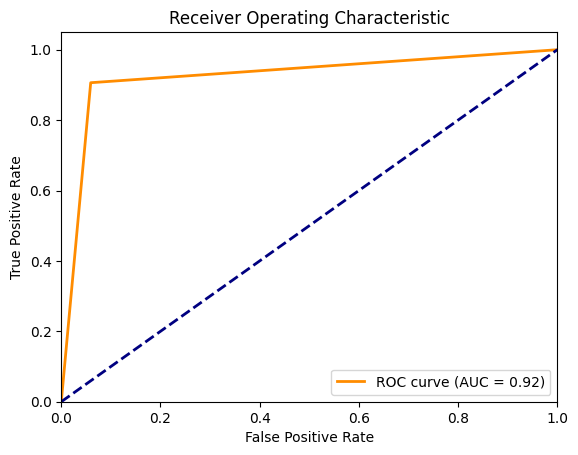

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()